In [1]:
import pandas as pd
import numpy as np
from gurobipy import Model, GRB, Env
import pandas as pd
import math
import warnings
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import pandas as pd


warnings.filterwarnings('ignore')



In [2]:

df_elering = pd.read_csv('../Data_folder/da_and_fake_pred.csv', sep=';')

df_btd = pd.read_csv('../Data_folder/btd_nec.csv', sep=';')


# OPTIMIZATION ITSELF

In [3]:
#Constants

T_total = len(df_elering) 
opt_window = 168  # Optimization window in hours - change based on how much we believe should be looked into
shift_period = 24  # Shift period for starting new optimization in hours
B_max = 53.1  # Max battery capacity in MWh
max_charge_discharge_rate = 26.5  # Max charge/discharge rate in MW - sets also the boundary for max MWh that can be dissipated
Eff= 0.95
dataframes_opt = {}

E_a = 31500  # Activation energy in J/mol
R = 8.314  # Universal gas constant in J/(mol*K)
z = 0.552
E_rate = 53.1  # Rated capacity of the battery in MWh
T = 300  # Temperature in Kelvinz
C= 19e6
A = 330.330
Eff = 0.95

def Q_cycle(h, E_rate_joules, A, E_a, R, T, z):
    return A * np.exp(-E_a / (R * T)) * (h * E_rate_joules)**z

h_values_fraction = np.linspace(0.1, 1, 101)


Q_loss_mwh_values_per_MWh = [Q_cycle(h, E_rate, A, E_a, R, T, z)*(19e6/53.1) / (h*53.1) for h in h_values_fraction]

# New part

In [4]:


mean_value = {}
mean_value['mfrr_price_approx_upward'] = np.mean(df_btd['mfrr_price_approx_upward'])
mean_value['mfrr_price_approx_downward'] = np.mean(df_btd['mfrr_price_approx_downward'])

def noisify_with_mae(start, periods):
    np.random.seed(13)
    df = df_btd.copy()
    
    columns_to_modify = [
        'mfrr_price_approx_upward', 
        'mfrr_price_approx_downward',
    ]

    mae_values = [0, 0, 0 , 0 , 0, 0 , 0, 0]  # Ideal MAE values
    df_noisy = pd.DataFrame()
    
    for column in columns_to_modify:
        values = df[column].iloc[start:start+periods]
        mean = mean_value[column]
        noisy_values = [value + mae * np.random.choice([-1, 1]) * np.random.normal(1, 1)
                        for value, mae in zip(values, mae_values)]
        df_noisy[column] = noisy_values

    df_noisy['imbalance_p'] = list(df['imbalance_p_estonia_none'].iloc[start:start+periods])
    df_noisy['real_up'] = list(df['mfrr_price_approx_upward'].iloc[start:start+periods])
    df_noisy['real_down'] = list(df['mfrr_price_approx_downward'].iloc[start:start+periods])
    df_noisy['mfrr_act_baltics_downward'] = list(df['mfrr_act_baltics_downward'].iloc[start:start+periods])
    df_noisy['mfrr_act_baltics_upward'] = list(df['mfrr_act_baltics_upward'].iloc[start:start+periods])
    
    return df_noisy

In [5]:


def mfrr_optimisation(initial_soc, acc_profit_mfrr, da_results, acc_depreciation_mfrr, opt_window_mfrr = 8, 
                      B_max = 53.1, max_charge_discharge_rate = 26.5, eff = 0.95, shift_mfrr = 1, 
                      T_mfrr_total = len(df_btd), up_max = 100, down_max = 100):
    mfrr_window_results = {}
    opt_window_mfrr = 8
    range_of = 48
   # print(da_results)
    add_to_mfrr_hour = da_results['Hour'].iloc[0]
    da_results = da_results.reset_index(drop= True)
    mfrr_window_results = {}

    true_range = min(range_of, len(da_results))

    for window_mfrr_start in range(0, true_range-7, shift_mfrr):        
        end_hour_mfrr = min(window_mfrr_start + opt_window_mfrr, len(da_results))

        try:
            aa = [da_results.at[t + window_mfrr_start, 'Charge (MWh)'] for t in range(opt_window_mfrr)]
        except:
            print(len(da_results))
        
        mfrr_data = noisify_with_mae(add_to_mfrr_hour + window_mfrr_start, opt_window_mfrr)
        
        mFRR = Model("mFRR_Optimization")
        mFRR.Params.LogToConsole = 0
        
        Downward_mFRR = mFRR.addVars(
            range(opt_window_mfrr), 
            lb=0, 
            ub=[min(
                    mfrr_data['mfrr_act_baltics_downward'].iloc[t], 
                    down_max, 
                    max_charge_discharge_rate - da_results.at[t + window_mfrr_start, 'Charge (MWh)']) for t in range(opt_window_mfrr)], 
            name="Downward_mFRR"
        )
        Upward_mFRR = mFRR.addVars(
            range(opt_window_mfrr), 
            lb=0, 
            ub=[min(
                    mfrr_data['mfrr_act_baltics_upward'].iloc[t],
                    up_max, 
                    max_charge_discharge_rate - da_results.at[t + window_mfrr_start, 'Discharge (MWh)']) for t in range(opt_window_mfrr)], 
            name="Upward_mFRR"
        )
        Imbalance_q_pos = mFRR.addVars(
            range(opt_window_mfrr), 
            lb=0, 
            ub=100, 
            name="Imbalance_q_pos"
        )
        
        Imbalance_q_neg = mFRR.addVars(
            range(opt_window_mfrr), 
            lb=-100, 
            ub=0, 
            name="Imbalance_q_neg"
        )

        Depreciation = mFRR.addVars(
            range(opt_window_mfrr), 
            lb=-10000000, 
            ub=1000000, 
            name="Depreciation"
        )
                
        StateOfCharge_mfrr = mFRR.addVars(range(opt_window), lb=0.05 * B_max, ub=0.95 * B_max, name="StateOfCharge_mfrr")
        
    
        mFRR.setObjective(
            sum((Upward_mFRR[t] * (mfrr_data['mfrr_price_approx_upward'].iloc[t]-Q_loss_mwh_values_per_MWh[math.floor(up_max/B_max *100)]) * eff - 
                 Downward_mFRR[t] * mfrr_data['mfrr_price_approx_downward'].iloc[t] - 
                 (Imbalance_q_pos[t]- Imbalance_q_neg[t]) * 10e9 -
                 (Imbalance_q_pos[t]- Imbalance_q_neg[t]) * mfrr_data['imbalance_p'].iloc[t]) 
                for t in range(opt_window_mfrr)),
            GRB.MAXIMIZE
        )
        
        # Define constraints
        for t in range(min(opt_window_mfrr, range_of - window_mfrr_start)):
            mFRR.addConstr(
                Depreciation[t] == Upward_mFRR[t] * 55.6,
                name=f"Depreciation{t}"
            )
            if t == 0:
                mFRR.addConstr(
                    StateOfCharge_mfrr[t] == initial_soc - Upward_mFRR[t] + Downward_mFRR[t]*eff+ Imbalance_q_pos[t] + Imbalance_q_neg[t],
                    name=f"StateOfCharge_mfrr{t}"
                )
            else:
               # print(t)
                mFRR.addConstr(
                    StateOfCharge_mfrr[t] == StateOfCharge_mfrr[t-1] + da_results.at[t + window_mfrr_start, 'Charge (MWh)'] * eff - da_results.at[t + window_mfrr_start, 'Discharge (MWh)']
                    - Upward_mFRR[t] + Downward_mFRR[t]*eff+ Imbalance_q_pos[t] + Imbalance_q_neg[t],
                    name=f"StateOfCharge_mfrr{t}"
                )
        
        mFRR.optimize()
        
        if mFRR.status == GRB.OPTIMAL:
            soc_at_shift_end = min(shift_mfrr, end_hour - window_start - 1) 
            initial_soc = (initial_soc + da_results.at[soc_at_shift_end + window_mfrr_start, 'Charge (MWh)'] * eff - da_results.at[soc_at_shift_end + window_mfrr_start, 'Discharge (MWh)']
                           - Upward_mFRR[soc_at_shift_end-1].X + Downward_mFRR[soc_at_shift_end-1].X*eff+ Imbalance_q_pos[soc_at_shift_end-1].X + Imbalance_q_neg[soc_at_shift_end-1].X)

            hourly_profits_mfrr = [(Upward_mFRR[t].X * mfrr_data['real_up'].iloc[t]) - (Downward_mFRR[t].X * mfrr_data['real_down'].iloc[t])-Depreciation[t].X 
                                   for t in range(min(opt_window_mfrr, T_mfrr_total - window_mfrr_start))]
            acc_profits_mfrr = [sum(hourly_profits_mfrr[:s+1]) + acc_profit_mfrr for s in range(len(hourly_profits_mfrr))]                  
            acc_profit_mfrr = acc_profits_mfrr[1]

            hourly_depreciation_mfrr = [Depreciation[t].X for t in range(min(opt_window_mfrr, T_mfrr_total - window_mfrr_start))]
            acc_depreciations_mfrr = [sum(hourly_depreciation_mfrr[:s+1]) + acc_depreciation_mfrr for s in range(len(hourly_profits_mfrr))]
            acc_depreciation_mfrr = acc_depreciations_mfrr[1]
            
            
            mFRR_results = pd.DataFrame({
                'Hour': da_results['Hour'].iloc[window_mfrr_start:end_hour_mfrr],
                'Charge (MWh)': da_results['Charge (MWh)'].iloc[window_mfrr_start:end_hour_mfrr],
                'Discharge (MWh)': da_results['Discharge (MWh)'].iloc[window_mfrr_start:end_hour_mfrr],
                'State of Charge (MWh)': da_results['State of Charge (MWh)'].iloc[window_mfrr_start:end_hour_mfrr],
                'Downward mFRR (MWh)': [Downward_mFRR[t].X for t in range(min(opt_window_mfrr, T_mfrr_total - window_mfrr_start))],
                'Upward mFRR (MWh)': [Upward_mFRR[t].X for t in range(min(opt_window_mfrr, T_mfrr_total - window_mfrr_start))],
                'Imbalance (MWh)': [Imbalance_q_pos[t].X + Imbalance_q_neg[t].X for t in range(min(opt_window_mfrr, T_mfrr_total - window_mfrr_start))],
                'Imbalane (price)': [mfrr_data['imbalance_p'].iloc[t] for t in range(min(opt_window_mfrr, T_mfrr_total - window_mfrr_start))],
                'State of Charge mfrr (MWh)': [StateOfCharge_mfrr[t].X for t in range(min(opt_window_mfrr, T_mfrr_total - window_mfrr_start))],
                'initial_soc': initial_soc,
                'Price DA (CurrencyUnit)': da_results['Price (CurrencyUnit)'].iloc[window_mfrr_start:end_hour_mfrr],
                'Price mFRR Up (CurrencyUnit)': [mfrr_data['real_up'].iloc[t] for t in range(min(opt_window_mfrr, T_mfrr_total - window_mfrr_start))],
                'Price mFRR Down (CurrencyUnit)': [mfrr_data['real_down'].iloc[t] for t in range(min(opt_window_mfrr, T_mfrr_total - window_mfrr_start))],
                'MOCK Price mFRR Down (CurrencyUnit)': [mfrr_data['mfrr_price_approx_downward'].iloc[t] for t in range(min(opt_window_mfrr, T_mfrr_total - window_mfrr_start))],
                'mFRR Up limit': [mfrr_data['mfrr_act_baltics_upward'].iloc[t]for t in range(min(opt_window_mfrr, T_mfrr_total - window_mfrr_start))],

                'Accumulated Profit (CurrencyUnit)': [da_results.at[t, 'Accumulated Profit (CurrencyUnit)'] for t in range(window_mfrr_start, end_hour_mfrr)],
                'mFRR Profit (CurrencyUnit)': acc_profits_mfrr,
                
                'start': window_mfrr_start,
                'hourly profit': hourly_profits_mfrr,
                'depreciation': acc_depreciations_mfrr
        
            })
    
            window_df = pd.DataFrame(mFRR_results)
            mfrr_window_results[f"Window_{window_mfrr_start}"] = window_df
    
        elif status == GRB.INFEASIBLE:
            print('Did not work')
            break



    df_list = []

    sorted_keys = sorted(mfrr_window_results.keys(), key=lambda x: int(x.split("_")[1]))
    
    up = 0
    down = 0
    for key in sorted_keys:
        df = mfrr_window_results[key] 
       
        df_list.append(df)
    
    concatenated_df = pd.concat(df_list)
    
    final_df = concatenated_df.drop_duplicates(subset=['Hour'], keep='last')
    
    final_df.reset_index(drop=True, inplace=True)
    
    final_df = final_df.iloc[:30]
                      
        
    return final_df




## LOOP

In [6]:
def calculate_loss_da(row):
    index = int(np.floor(row['Discharge (MWh)'] / B_max * 100))
    return Q_loss_mwh_values_per_MWh[index]


def calculate_loss_mfrr(row):
    index = int(np.floor(row['Upward mFRR (MWh)'] / B_max * 100))
    return Q_loss_mwh_values_per_MWh[index]

In [7]:
window_results = {}

license_options = {
    "WLSACCESSID": "0935398f-594a-47ee-8d53-2c9e304eafbe",
    "WLSSECRET": "b83a5692-5d2e-4229-98f1-bd4d5846464c",
    "LICENSEID": 2478922,
}

env = Env(params=license_options)

env.start()


for s in range(27, 28):
    dataframe_name = f'opt_w_max_mfrr_{s}'
    # Configuration
    acc_profit_mfrr = 0
    acc_depreciation_mfrr = 0
    initial_soc = 0.05 * B_max  # minimum of the battery
    acc_profit = 0  # accumulated profit 
    
    
    for window_start in range(0, T_total, shift_period):
        end_hour = min(window_start + opt_window, T_total)
        P_price = df_elering['DA_price'].iloc[window_start:end_hour].tolist() 
        
        m = Model()
        m.Params.LogToConsole = 0
    
        Charge = m.addVars(range(opt_window), lb=0, ub=max_charge_discharge_rate, name="Charge")
        Discharge = m.addVars(range(opt_window), lb=0, ub=max_charge_discharge_rate, name="Discharge")
        StateOfCharge = m.addVars(range(opt_window), lb=0.05 * B_max, ub=0.95 * B_max, name="StateOfCharge")
        
          
        has_discharged = m.addVar(vtype=GRB.BINARY, name="has_discharged")
        
        m.addConstr(has_discharged * max_charge_discharge_rate * opt_window >= sum(Discharge[t] for t in range(min(opt_window, len(P_price)))), 
                    name="link_has_discharged")
        
        m.setObjective(
            sum((Discharge[t] * Eff * (P_price[t] - Q_loss_mwh_values_per_MWh[math.floor(26.5/B_max *100)]) 
            - Charge[t] * (P_price[t]))
                for t in range(min(opt_window, len(P_price)))),
            GRB.MAXIMIZE
        )
    
        # Initial SoC constraint
        m.addConstr(StateOfCharge[0] == initial_soc, name="InitialSOC")
    
        # The initial discharge constraint
        m.addConstr(Discharge[0] <= initial_soc - 0.05 * B_max, name="DischargeLimitAtT0")
        
        # SoC constraints
        for t in range(0, min(opt_window, len(P_price))):
            if t == 0:
                m.addConstr(StateOfCharge[t] == initial_soc - Discharge[t] + Charge[t] * Eff, name=f"SOC_{t}")
            else:
                m.addConstr(StateOfCharge[t] == StateOfCharge[t-1] - Discharge[t] + Charge[t] * Eff, name=f"SOC_{t}")
    
        
        m.optimize()
        
    
        
        if m.status == GRB.OPTIMAL:
            da_price = df_elering['DA_price'].iloc[window_start:end_hour].tolist()
            hourly_profits = [(Discharge[t].X * Eff - Charge[t].X) * da_price[t] - 
                              float(Discharge[t].X) * Q_loss_mwh_values_per_MWh[math.floor(Discharge[t].X/B_max *100)] 
                              for t in range(min(opt_window, len(P_price)))]
            acc_profits = [sum(hourly_profits[:t+1]) + acc_profit for t in range(len(hourly_profits))]
            acc_profit = acc_profits[min(23, len(acc_profits))]  
            data = {
                "Hour": list(range(window_start, window_start + len(hourly_profits))),
                "Charge (MWh)": [Charge[t].X for t in range(min(opt_window, len(P_price)))],
                "Discharge (MWh)": [Discharge[t].X for t in range(min(opt_window, len(P_price)))],
                "State of Charge (MWh)": [StateOfCharge[t].X for t in range(min(opt_window, len(P_price)))],
                "Price (CurrencyUnit)": da_price,
                "Accumulated Profit (CurrencyUnit)": acc_profits,
            }
    
            window_df = pd.DataFrame(data)
            window_df = mfrr_optimisation(initial_soc = window_df['State of Charge (MWh)'].iloc[0], 
                                          acc_profit_mfrr = acc_profit_mfrr, 
                                          da_results = window_df, 
                                          acc_depreciation_mfrr = acc_depreciation_mfrr,
                                          up_max = s, down_max = s)
            acc_profit_mfrr += window_df['mFRR Profit (CurrencyUnit)'].iloc[min(23, end_hour - window_start - 1)]
            acc_depreciation_mfrr += window_df['depreciation'].iloc[min(23, end_hour - window_start - 1)]
            
            soc_at_shift_end = min(23, end_hour - window_start - 1) 
            initial_soc = window_df['State of Charge mfrr (MWh)'].iloc[soc_at_shift_end]
            window_results[f"Window_{window_start}"] = window_df
    
    df_list = []
    
    sorted_keys = sorted(window_results.keys(), key=lambda x: int(x.split("_")[1]))
    
    for key in sorted_keys:
        df = window_results[key]
        df_list.append(df)
    
    concatenated_df = pd.concat(df_list)
    
    final_df = concatenated_df.drop_duplicates(subset=['Hour'], keep='last')
    
    final_df.reset_index(drop=True, inplace=True)
    
    #mfrr
    final_df['Q_loss_mfrr'] = final_df.apply(calculate_loss_mfrr, axis=1)
    
    final_df['real_mfrr_profit'] = (final_df['Upward mFRR (MWh)']* 0.95 * (final_df['Price mFRR Up (CurrencyUnit)']) - 
                                    final_df['Downward mFRR (MWh)'] * final_df['Price mFRR Down (CurrencyUnit)'] -
                                    final_df['Q_loss_mfrr'] * final_df['Upward mFRR (MWh)']
                                   )
    acc_cum_mfrr_profits = [sum(final_df['real_mfrr_profit'].iloc[:t+1]) for t in range(len(final_df))]
    final_df['real_cum_mfrr_profit'] = acc_cum_mfrr_profits


    #DA
    # Apply the function to calculate Q_loss for each row
    final_df['Q_loss_da'] = final_df.apply(calculate_loss_da, axis=1)
    
    # Calculate real_da_profit using the newly calculated Q_loss
    final_df['real_da_profit'] = (
        final_df['Discharge (MWh)'] * 0.95 * final_df['Price DA (CurrencyUnit)'] -
        final_df['Charge (MWh)'] * final_df['Price DA (CurrencyUnit)'] -
        final_df['Q_loss_da'] * final_df['Discharge (MWh)']
    )

    
    acc_cum_da_profits = [sum(final_df['real_da_profit'].iloc[:t+1]) for t in range(len(final_df))]
    final_df['real_cum_da_profit'] = acc_cum_da_profits
    
    #Total
    final_df['real_profit'] = (final_df['real_mfrr_profit'] + final_df['real_da_profit'] -
                              final_df['Imbalance (MWh)'] * final_df['Imbalane (price)'])
    acc_cumprofits = [sum(final_df['real_profit'].iloc[:t+1]) for t in range(len(final_df))]
    final_df['real_cum_total_profit'] = acc_cumprofits
                            


    
    
    final_df['real_soc'] = final_df['State of Charge (MWh)']  - final_df['Upward mFRR (MWh)'] + final_df['Downward mFRR (MWh)']
    
    
    final_df['real_soc'] = final_df['State of Charge (MWh)'].iloc[0] + (final_df['Downward mFRR (MWh)']*0.95  - final_df['Upward mFRR (MWh)'] - final_df['Discharge (MWh)'] + final_df['Imbalance (MWh)'] + final_df['Charge (MWh)']*0.95).cumsum()

    dataframes_opt[dataframe_name] = final_df




Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2478922
Academic license 2478922 - for non-commercial use only - registered to ol___@ut.ee
Restricted license - for non-production use only - expires 2025-11-24


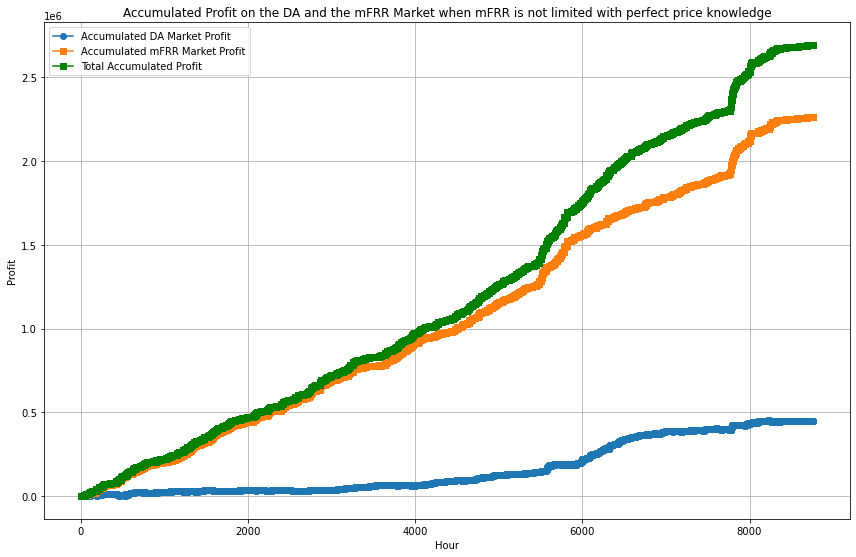

In [8]:


mfrr_limit = 27

final_df_key = f'opt_w_max_mfrr_{mfrr_limit}'
final_df = dataframes_opt[final_df_key]

plt.figure(figsize=(12, 8))
plt.plot(final_df['Hour'], final_df['real_cum_da_profit'], '-o', label='Accumulated DA Market Profit')
plt.plot(final_df['Hour'], final_df['real_cum_mfrr_profit'], '-s', label='Accumulated mFRR Market Profit')
plt.plot(final_df['Hour'], final_df['real_cum_total_profit'], '-s', label='Total Accumulated Profit', color='green')
plt.title(f'Accumulated Profit on the DA and the mFRR Market when mFRR is not limited with perfect price knowledge')
plt.xlabel('Hour')
plt.ylabel('Profit')
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.savefig(f'limit_perf_{mfrr_limit}.pdf')

plt.show()


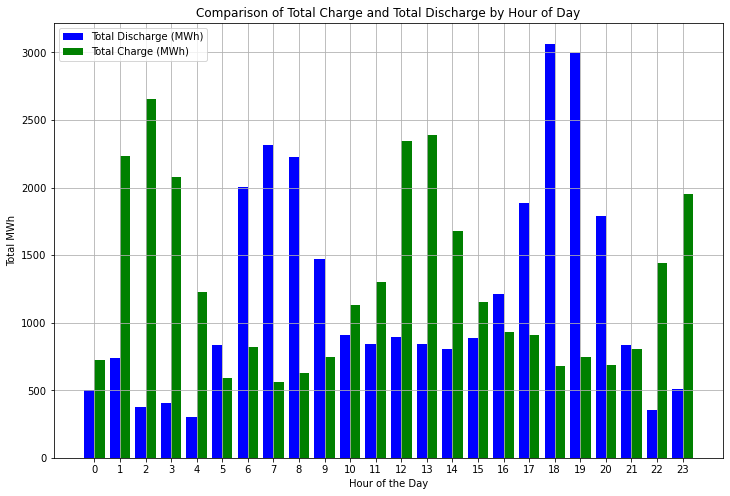

In [9]:

final_df['hour_of_day'] = final_df['Hour'] % 24

grouped_data = final_df.groupby('hour_of_day').agg({
    'Discharge (MWh)': 'sum',
    'Charge (MWh)': 'sum',
    'Upward mFRR (MWh)': 'sum',
    'Downward mFRR (MWh)': 'sum'
}).reset_index()

grouped_data['Total Discharge (MWh)'] = grouped_data['Discharge (MWh)'] + grouped_data['Upward mFRR (MWh)']
grouped_data['Total Charge (MWh)'] = grouped_data['Charge (MWh)'] + grouped_data['Downward mFRR (MWh)']

plt.figure(figsize=(12, 8))
plt.bar(grouped_data['hour_of_day'] - 0.2, grouped_data['Total Discharge (MWh)'], width=0.4, label='Total Discharge (MWh)', color='blue')
plt.bar(grouped_data['hour_of_day'] + 0.2, grouped_data['Total Charge (MWh)'], width=0.4, label='Total Charge (MWh)', color='green')

plt.xlabel('Hour of the Day')
plt.ylabel('Total MWh')
plt.title('Comparison of Total Charge and Total Discharge by Hour of Day')
plt.xticks(grouped_data['hour_of_day'])
plt.legend()
plt.grid(True)
plt.show()


In [10]:

all_results_df = pd.DataFrame()

for mfrr_limit in range(27, 28):
    final_df_key = f'opt_w_max_mfrr_{mfrr_limit}'
    final_df = dataframes_opt[final_df_key]

    final_df['imb_price'] = final_df['Imbalance (MWh)'] * final_df['Imbalane (price)']

    max_accumulated_profit = round(final_df['real_cum_da_profit'].max())
    max_real_cum_total_profit = round(final_df['real_cum_total_profit'].max())
    max_real_cum_mfrr_profit = round(final_df['real_cum_mfrr_profit'].max())
    total_imb_price = round( final_df['real_cum_da_profit'].max()+
                           final_df['real_cum_mfrr_profit'].max()-
                           final_df['real_cum_total_profit'].max())
    total_upward_mfrr = round(final_df['Upward mFRR (MWh)'].sum())
    total_downward_mfrr = round(final_df['Downward mFRR (MWh)'].sum())
    total_charge = round(final_df['Charge (MWh)'].sum())
    total_discharge = round(final_df['Discharge (MWh)'].sum())
    total_neg_imb = round(final_df[final_df['Imbalance (MWh)'] > 0]['Imbalance (MWh)'].sum())
    total_pos_imb = abs(round(final_df[final_df['Imbalance (MWh)'] < 0]['Imbalance (MWh)'].sum()))


    data = {
        'mfrr_limit': [mfrr_limit],
        'Cumulative Total Profit': [max_real_cum_total_profit],
        'Cumulative DA Market Profit': [max_accumulated_profit],
        'Cumulative mFRR Market Profit': [max_real_cum_mfrr_profit],
        'Cumulative Imbalance losses': [total_imb_price],
        'Total Upward mFRR (MWh)': [total_upward_mfrr],
        'Total Downward mFRR (MWh)': [total_downward_mfrr],
        'Total Charge (MWh)': [total_charge],
        'Total Discharge (MWh)': [total_discharge],
        'Total negative imbalance': [total_neg_imb],
        'Total positive imbalance': [total_pos_imb]
        
    }
    
    temp_df = pd.DataFrame(data)
    
    all_results_df = pd.concat([all_results_df, temp_df], ignore_index=True)

all_results_df


,mfrr_limit,Cumulative Total Profit,Cumulative DA Market Profit,Cumulative mFRR Market Profit,Cumulative Imbalance losses,Total Upward mFRR (MWh),Total Downward mFRR (MWh),Total Charge (MWh),Total Discharge (MWh),Total negative imbalance,Total positive imbalance
0,27,2692032,452172,2263286,23426,17325,17642,12783,11684,282,177
